In [8]:
import warnings

In [9]:
warnings.filterwarnings("ignore")

#### Import required models

In [10]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

#### Load the dataset

In [4]:
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", index_col=0, parse_dates=True)

In [5]:
data.head()

Next Date  HCHO reading
Current Date                          
2019-01-01    2019-01-02      0.000088
2019-01-02    2019-01-03      0.000137
2019-01-03    2019-01-04      0.000148
2019-01-04    2019-01-05     -0.000002
2019-01-05    2019-01-06      0.000249

#### Do Not consider Next Date for Single Variate Models

In [6]:
kurunegala_data = data[["HCHO reading"]]
kurunegala_data.head()   

HCHO reading
Current Date              
2019-01-01        0.000088
2019-01-02        0.000137
2019-01-03        0.000148
2019-01-04       -0.000002
2019-01-05        0.000249

In [38]:
kurunegala_data.shape  

(1826, 1)

In [39]:
X = kurunegala_data.values  

#### This looks like that Kurunegala fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

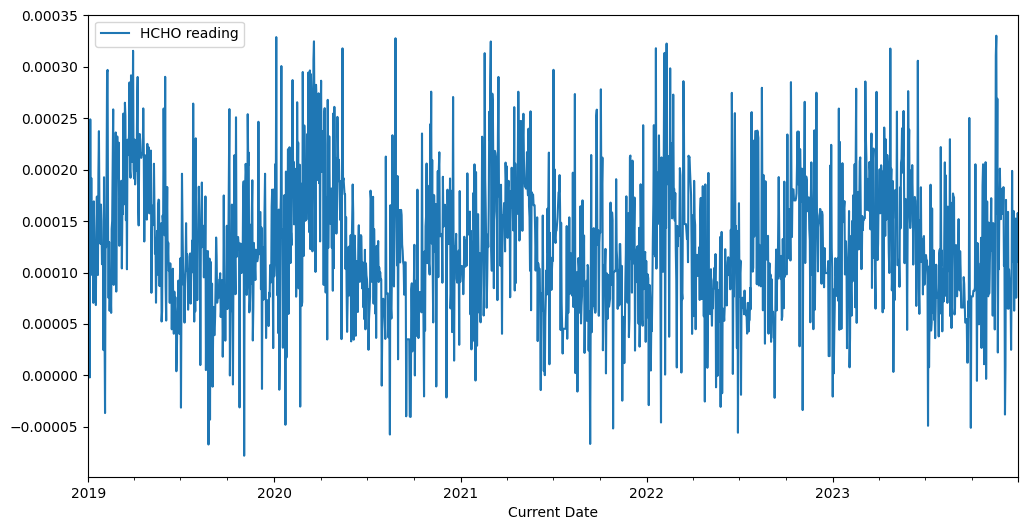

In [10]:
kurunegala_data.plot(figsize=(12, 6)) 

In [11]:
from statsmodels.tsa.stattools import adfuller

In [13]:
test_kurunegala = adfuller(kurunegala_data["HCHO reading"], autolag="AIC") 

#### Check ADF and P values for Kurunegala HCHO distribution

In [14]:
print("ADF value : ", test_kurunegala[0])
print("P value: ", test_kurunegala[1])
print("Num of Lags :", test_kurunegala[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_kurunegala[3])
for key, val in test_kurunegala[4].items():
    print("\t", key, ": ", val)

ADF value :  -5.850232148878149
P value:  3.603706776152739e-07
Num of Lags : 10
Num of Observations used for ADF Regression and Critical Calculation : 1815
	 1% :  -3.4339580289794225
	 5% :  -2.8631337437669275
	 10% :  -2.567618456010139


#### Since there is a very low P value for the above dataset. There is no need of using differencing 
#### techniques.

#### Auto correlation and correlation plot for Kurunegala

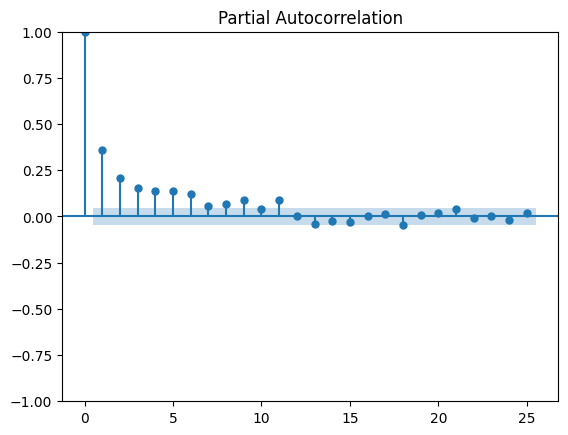

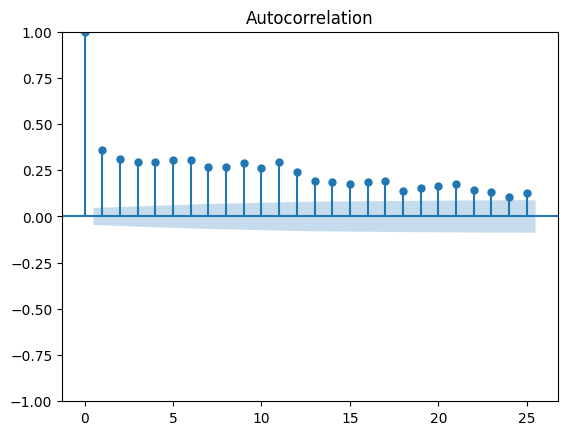

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(kurunegala_data["HCHO reading"], lags=25)
acf = plot_acf(kurunegala_data["HCHO reading"], lags=25)  

#### There is a seasonality in the Kurunegala data set

## Kurunegala LSTM

In [19]:
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [20]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000088
1   2019-01-02      0.000137
2   2019-01-03      0.000148
3   2019-01-04     -0.000002
4   2019-01-05      0.000249


#### Train the Kurunegala LSTM model

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 84s 842ms/step - loss: 0.9823 - mean_squared_error: 0.9823 - val_loss: 0.7231 - val_mean_squared_error: 0.7231
Epoch 2/100
37/37 [==============================] - 15s 400ms/step - loss: 0.8821 - mean_squared_error: 0.8821 - val_loss: 0.7713 - val_mean_squared_error: 0.7713
Epoch 3/100
37/37 [==============================] - 14s 364ms/step - loss: 0.8587 - mean_squared_error: 0.8587 - val_loss: 0.7486 - val_mean_squared_error: 0.7486
Epoch 4/100
37/37 [==============================] - 21s 561ms/step - loss: 0.8567 - mean_squared_error: 0.8567 - val_loss: 0.7961 - val_mean_squared_error: 0.7961
Epoch 5/100
37/37 [==============================] - 21s 557ms/step - loss: 0.8287 - mean_squared_error: 0.8287 - val_loss: 0.6886 - val_mean_squared_error: 0.6886
Epoch 6/100
37/37 [==============================] - 14s 380ms/step - loss: 0.8254 - mean_squared_error: 0.8254 - val_loss: 0.7524 - val_mean_squared_error: 0.7524
Epoch 7/100
37/3

Epoch 51/100
37/37 [==============================] - 4s 121ms/step - loss: 0.7307 - mean_squared_error: 0.7307 - val_loss: 0.7365 - val_mean_squared_error: 0.7365
Epoch 52/100
37/37 [==============================] - 5s 129ms/step - loss: 0.7310 - mean_squared_error: 0.7310 - val_loss: 0.7144 - val_mean_squared_error: 0.7144
Epoch 53/100
37/37 [==============================] - 4s 120ms/step - loss: 0.7195 - mean_squared_error: 0.7195 - val_loss: 0.7407 - val_mean_squared_error: 0.7407
Epoch 54/100
37/37 [==============================] - 4s 116ms/step - loss: 0.7290 - mean_squared_error: 0.7290 - val_loss: 0.7516 - val_mean_squared_error: 0.7516
Epoch 55/100
37/37 [==============================] - 4s 116ms/step - loss: 0.7011 - mean_squared_error: 0.7011 - val_loss: 0.7449 - val_mean_squared_error: 0.7449
Epoch 56/100
37/37 [==============================] - 5s 124ms/step - loss: 0.7065 - mean_squared_error: 0.7065 - val_loss: 0.7906 - val_mean_squared_error: 0.7906
Epoch 57/100
37/

#### The Kurunegala LSTM model has caught the seasonal pattern with fluctuations in its predictions

12/12 [==============================] - 5s 35ms/step


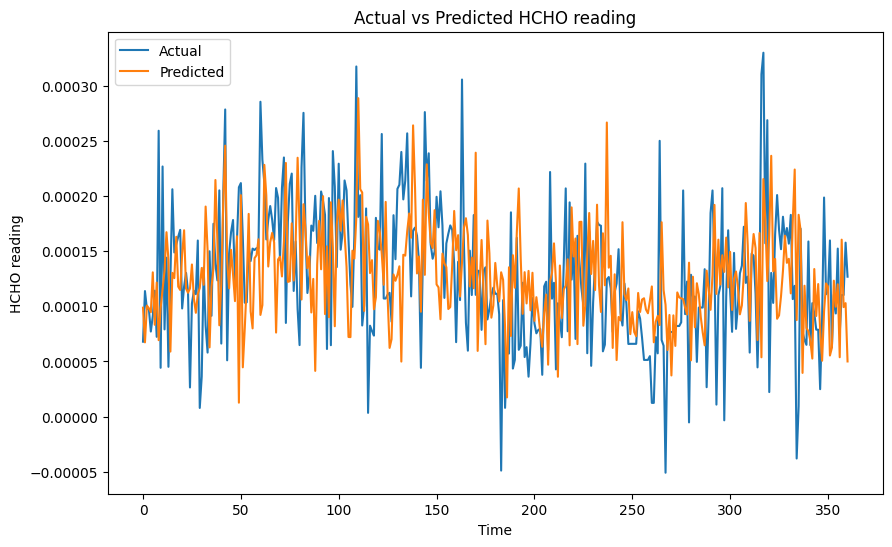

In [22]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### It has even caught the pattern of the training dataset

46/46 [==============================] - 1s 32ms/step


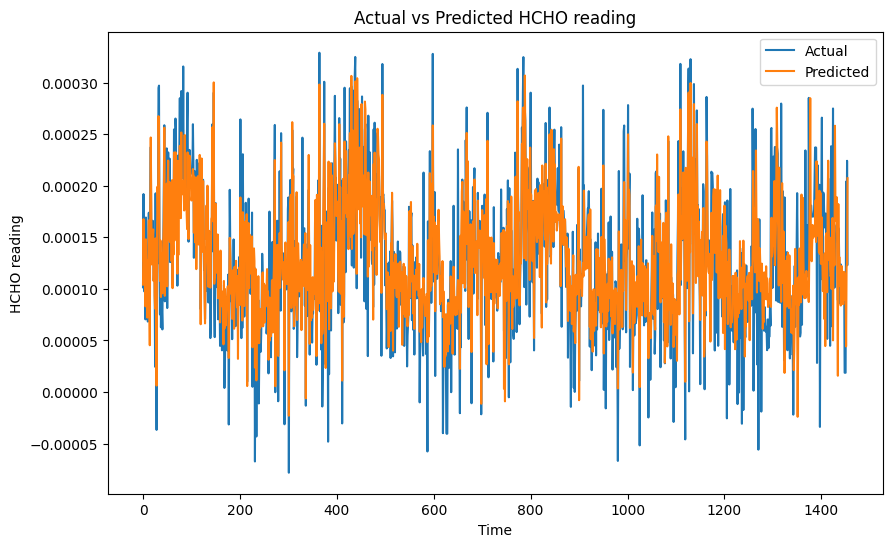

In [23]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### show how the model forecast it values fore testing dataset

46/46 [==============================] - 1s 31ms/step


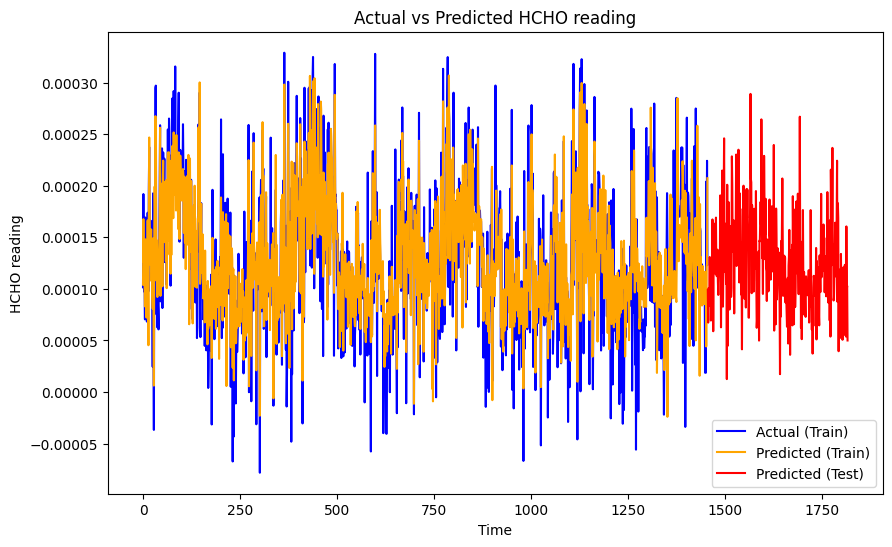

In [24]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### Model Testing Scores

#### This model has gained the best mse, mae and R2 score values

In [25]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.6443692206090519
Mean Absolute Error (MAE): 2.8479143137776713e-05
Mean Squared Error (MSE): 1.6546962253276127e-09
Root Mean Squared Error (RMSE): 4.067795748716512e-05
Median Absolute Error: 1.9996354830906156e-05
Explained Variance Score: 0.6456126878718855


#### Train the Facebook Prophet Model

00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:29 - cmdstanpy - INFO - Chain [1] done processing


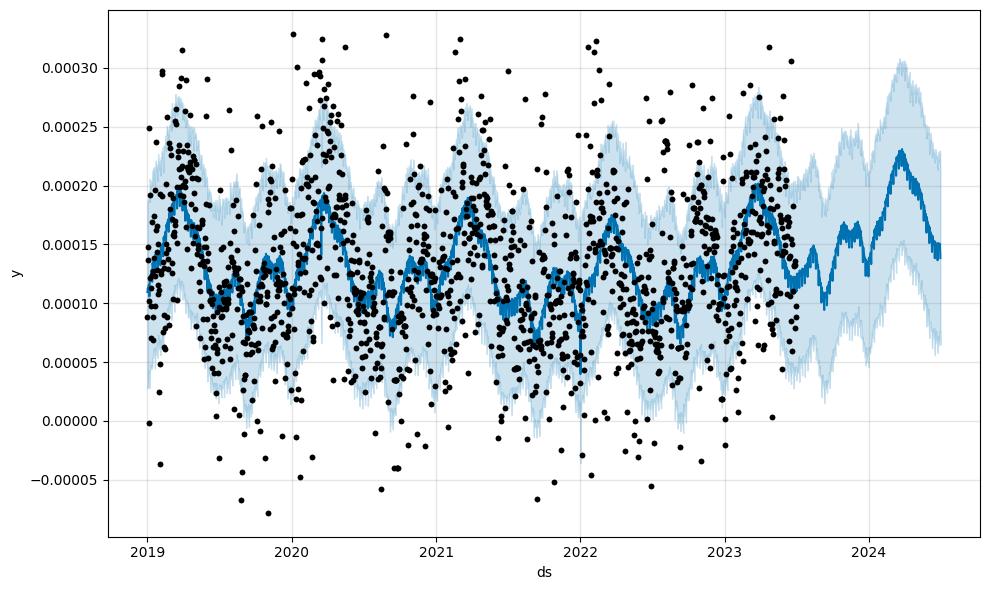

In [109]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,
               changepoint_prior_scale=0.3, 
               seasonality_prior_scale=5,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

#### Even this prophet model predicts values in a specific range, it has not caught the seasonal pattern as in Colombo City

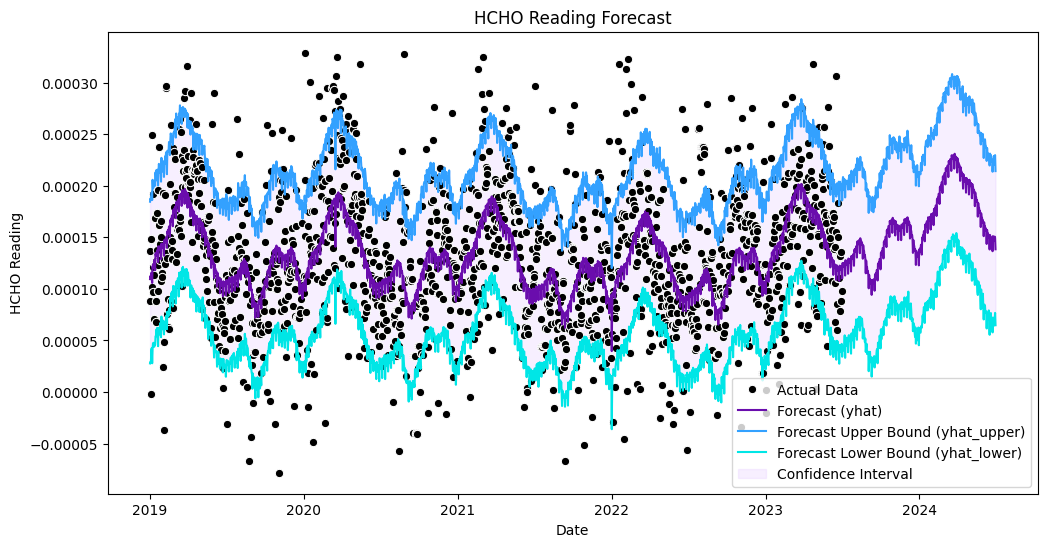

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

#### Trends given by the predicted values of the dataset

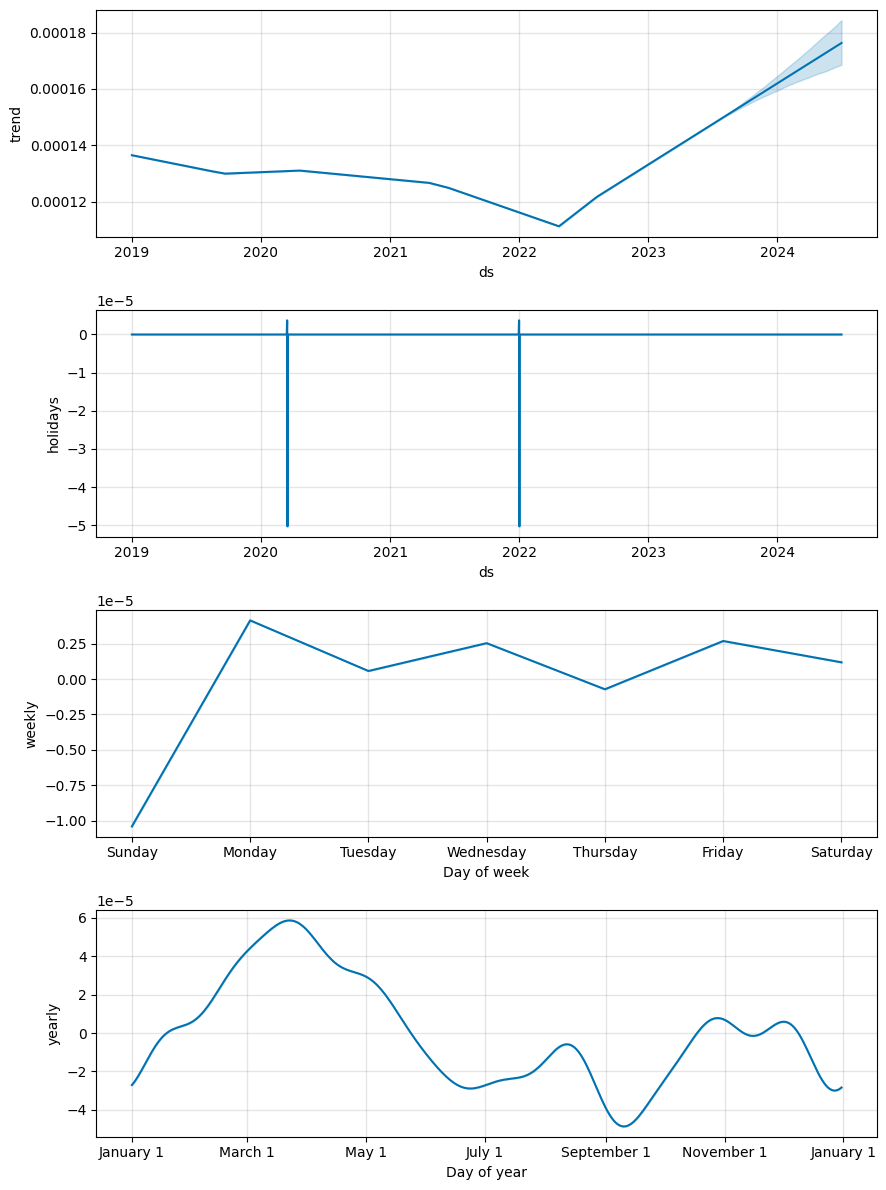

In [111]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

#### It has given a negative R2 score, therefore this cannot be considered as the best model to use

In [112]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.25792078454468204
Mean Absolute Error (MAE): 5.181082567927416e-05
Mean Squared Error (MSE): 4.260705314001012e-09
Root Mean Squared Error (RMSE): 6.527407842322259e-05
Median Absolute Error: 4.708687601755261e-05
Explained Variance Score: 0.07048579003635203


## Kurunegala Multi Variate Model

In [14]:
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

#### Get the information of the dataset

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   float64
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   float64
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [16]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
data.head()

Current Date  HCHO reading             Region  LATITUDE  LONGITUDE  \
0   2019-01-01      0.000088  Kurunegala Proper     7.467     80.367   
1   2019-01-02      0.000137  Kurunegala Proper     7.467     80.367   
2   2019-01-03      0.000148  Kurunegala Proper     7.467     80.367   
3   2019-01-04     -0.000002  Kurunegala Proper     7.467     80.367   
4   2019-01-05      0.000249  Kurunegala Proper     7.467     80.367   

   ELEVATION  PRCP  TAVG  TMAX  TMIN  Population  Area_sq_km  \
0      116.0   0.0  78.0  87.0  72.0       28571          11   
1      116.0   0.0  78.0  87.0  72.0       28571          11   
2      116.0   0.0  81.0  87.0  71.0       28571          11   
3      116.0   0.0  83.0  88.0  69.0       28571          11   
4      116.0   0.0  84.0  90.0  65.0       28571          11   

   population_density  Proximity(km)  carbon_monoxide  nitogen_dioxide  \
0             2597.36           59.5         0.035947         0.000007   
1             2597.36           59.5         0.036163         0.000011   
2             2597.36           59.5         0.032443         0.000010   
3             2597.36           59.5         0.034312         0.000009   
4             2597.36           59.5         0.033251         0.000009   

      ozone  new_covid_patients  total_covid_patients lockdown_status  \
0  0.115939                   0                     0          Before   
1  0.115939                   0                     0          Before   
2  0.115939                   0                     0          Before   
3  0.115939                   0                     0          Before   
4  0.115939                   0                     0          Before   

  covid_range_status  
0             Before  
1             Before  
2             Before  
3             Before  
4             Before

#### remove constant data

In [18]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [19]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)', 'Population', 'population_density'], inplace=True)

In [20]:
data.head()

Current Date  HCHO reading  PRCP  TAVG  TMAX  TMIN  carbon_monoxide  \
0   2019-01-01      0.000088   0.0  78.0  87.0  72.0         0.035947   
1   2019-01-02      0.000137   0.0  78.0  87.0  72.0         0.036163   
2   2019-01-03      0.000148   0.0  81.0  87.0  71.0         0.032443   
3   2019-01-04     -0.000002   0.0  83.0  88.0  69.0         0.034312   
4   2019-01-05      0.000249   0.0  84.0  90.0  65.0         0.033251   

   nitogen_dioxide     ozone  new_covid_patients  total_covid_patients  \
0         0.000007  0.115939                   0                     0   
1         0.000011  0.115939                   0                     0   
2         0.000010  0.115939                   0                     0   
3         0.000009  0.115939                   0                     0   
4         0.000009  0.115939                   0                     0   

  lockdown_status covid_range_status  
0          Before             Before  
1          Before             Before  
2          Before             Before  
3          Before             Before  
4          Before             Before

#### Encode Categorical data

In [21]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [22]:
data["Current Date"] = dates
data.head()

Current Date  HCHO reading  PRCP  TAVG  TMAX  TMIN  carbon_monoxide  \
0   2019-01-01      0.000088   0.0  78.0  87.0  72.0         0.035947   
1   2019-01-02      0.000137   0.0  78.0  87.0  72.0         0.036163   
2   2019-01-03      0.000148   0.0  81.0  87.0  71.0         0.032443   
3   2019-01-04     -0.000002   0.0  83.0  88.0  69.0         0.034312   
4   2019-01-05      0.000249   0.0  84.0  90.0  65.0         0.033251   

   nitogen_dioxide     ozone  new_covid_patients  total_covid_patients  \
0         0.000007  0.115939                   0                     0   
1         0.000011  0.115939                   0                     0   
2         0.000010  0.115939                   0                     0   
3         0.000009  0.115939                   0                     0   
4         0.000009  0.115939                   0                     0   

   lockdown_status  covid_range_status  
0                1                   1  
1                1                   1  
2                1                   1  
3                1                   1  
4                1                   1

#### Check correlations

In [23]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr

HCHO reading
HCHO reading              1.000000
PRCP                     -0.020175
TAVG                      0.174568
TMAX                      0.342388
TMIN                     -0.095334
carbon_monoxide           0.276864
nitogen_dioxide           0.007006
ozone                    -0.075194
new_covid_patients       -0.057518
total_covid_patients     -0.074258
lockdown_status           0.037139
covid_range_status        0.018257

In [24]:
corr.to_csv("../OtherData/KurunegalaCorrelationData.csv")

In [25]:
data.shape

(1826, 13)

#### remove covid range status

In [26]:
data.drop(columns=["covid_range_status"], inplace=True)

#### Devide X and Y

In [27]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [28]:
X.head()

Current Date  PRCP  TAVG  TMAX  TMIN  carbon_monoxide  nitogen_dioxide  \
0   2019-01-01   0.0  78.0  87.0  72.0         0.035947         0.000007   
1   2019-01-02   0.0  78.0  87.0  72.0         0.036163         0.000011   
2   2019-01-03   0.0  81.0  87.0  71.0         0.032443         0.000010   
3   2019-01-04   0.0  83.0  88.0  69.0         0.034312         0.000009   
4   2019-01-05   0.0  84.0  90.0  65.0         0.033251         0.000009   

      ozone  new_covid_patients  total_covid_patients  lockdown_status  
0  0.115939                   0                     0                1  
1  0.115939                   0                     0                1  
2  0.115939                   0                     0                1  
3  0.115939                   0                     0                1  
4  0.115939                   0                     0                1

#### Select features based on Correlations

In [29]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.020175
TAVG                    0.174568
TMAX                    0.342388
TMIN                   -0.095334
carbon_monoxide         0.276864
nitogen_dioxide         0.007006
ozone                  -0.075194
new_covid_patients     -0.057518
total_covid_patients   -0.074258
lockdown_status         0.037139
Name: HCHO reading, dtype: float64

#### Plot the correlation Matrix

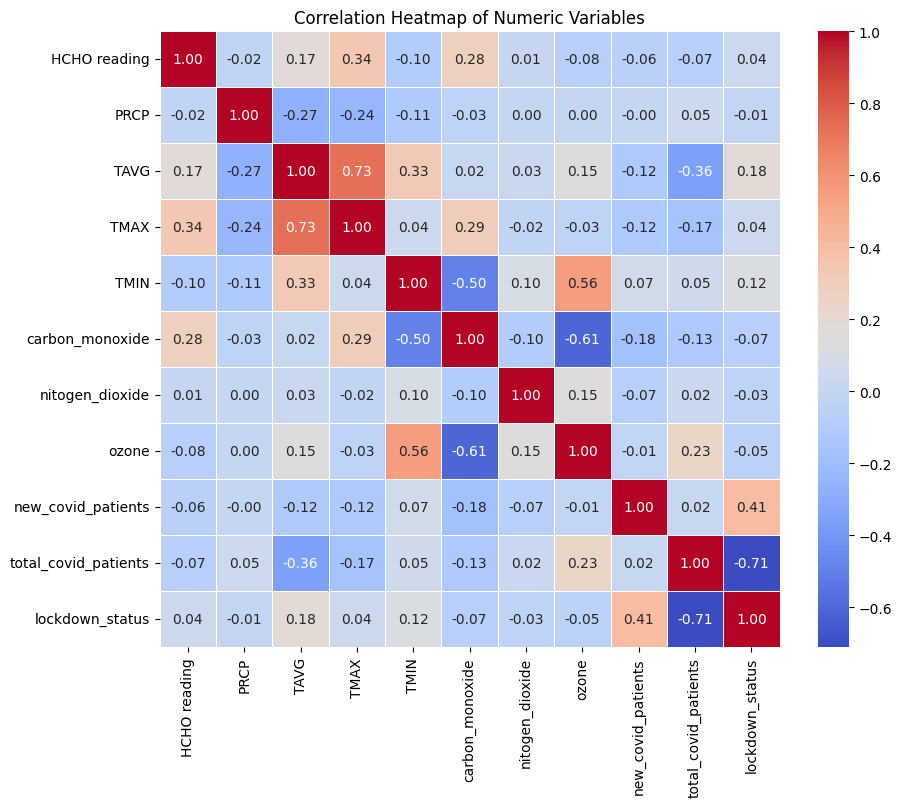

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is your DataFrame
correlation_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

#### Select the highest correlated columns for the correlation Matrix

In [31]:
X = X[["Current Date", "carbon_monoxide","TMAX"]]
X.head() 

Current Date  carbon_monoxide  TMAX
0   2019-01-01         0.035947  87.0
1   2019-01-02         0.036163  87.0
2   2019-01-03         0.032443  87.0
3   2019-01-04         0.034312  88.0
4   2019-01-05         0.033251  90.0

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Current Date     1826 non-null   object 
 1   carbon_monoxide  1826 non-null   float64
 2   TMAX             1826 non-null   float64
dtypes: float64(2), object(1)
memory usage: 42.9+ KB


#### Standardize, variable data

In [33]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["carbon_monoxide","TMAX"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carbon_monoxide  1826 non-null   float64
 1   TMAX             1826 non-null   float64
dtypes: float64(2)
memory usage: 42.8 KB


##### Standardize target variable

In [35]:
y = data['HCHO reading']

y.head()

0    0.000088
1    0.000137
2    0.000148
3   -0.000002
4    0.000249
Name: HCHO reading, dtype: float64

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [37]:
X_scaled = X

#### Plot the Standerdized HCHO distribution of Kurunegala City

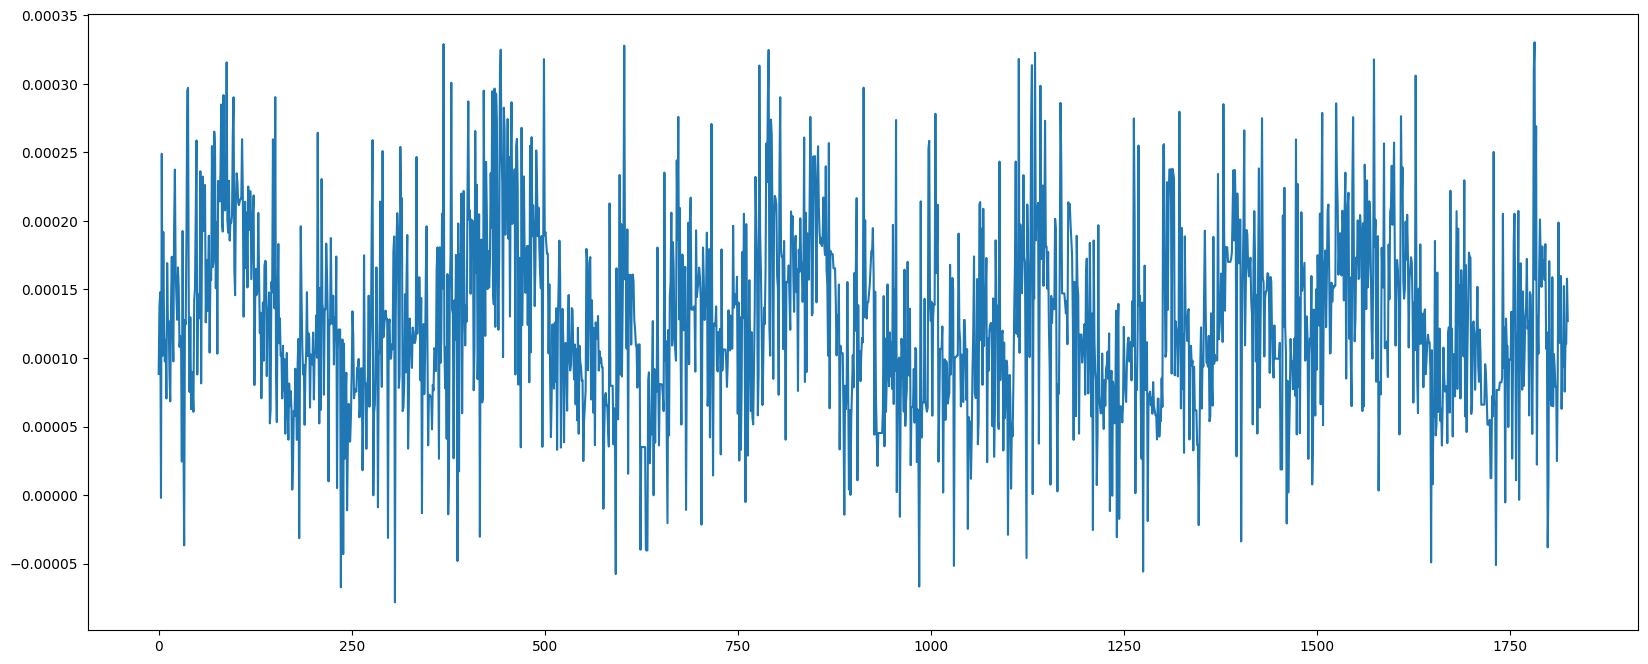

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [39]:
print(X_scaled.head())

              carbon_monoxide      TMAX
Current Date                           
2019-01-01           0.781534 -0.851669
2019-01-02           0.815476 -0.851669
2019-01-03           0.231763 -0.851669
2019-01-04           0.525000 -0.591436
2019-01-05           0.358602 -0.070972


#### Apply multivariate time series model

In [98]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]


model = Sequential([
    Bidirectional(LSTM(units=120, return_sequences=True, activation="relu"), input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    Bidirectional(LSTM(units=5)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

# Compilation of the model
optimizer = Adam(learning_rate=0.008)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
46/46 [==============================] - 10s 48ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 2/150
46/46 [==============================] - 1s 11ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 3/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 4/150
46/46 [==============================] - 0s 11ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 5/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 6/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 7/150
46/46 [========

46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 102/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 103/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 104/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 105/150
46/46 [==============================] - 0s 10ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 106/150
46/46 [==============================] - 0s 11ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 107/150
46/46 [=========

#### The below plot shows that it finds the seasonality of the data, but it does not catch the fluctuations

12/12 [==============================] - 0s 6ms/step - loss: 0.0204 - mean_squared_error: 0.0204
Test Loss: [0.02039891481399536, 0.02039891481399536]
12/12 [==============================] - 2s 4ms/step


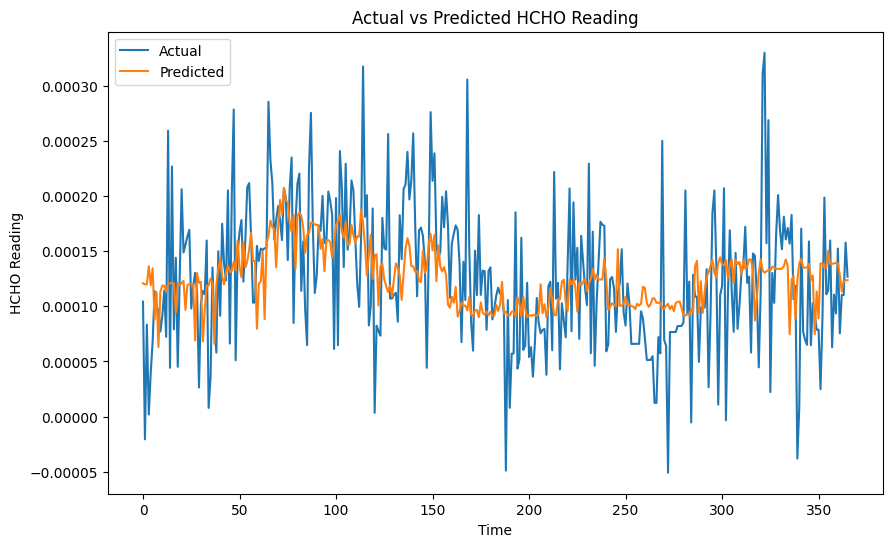

In [99]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 0s 4ms/step


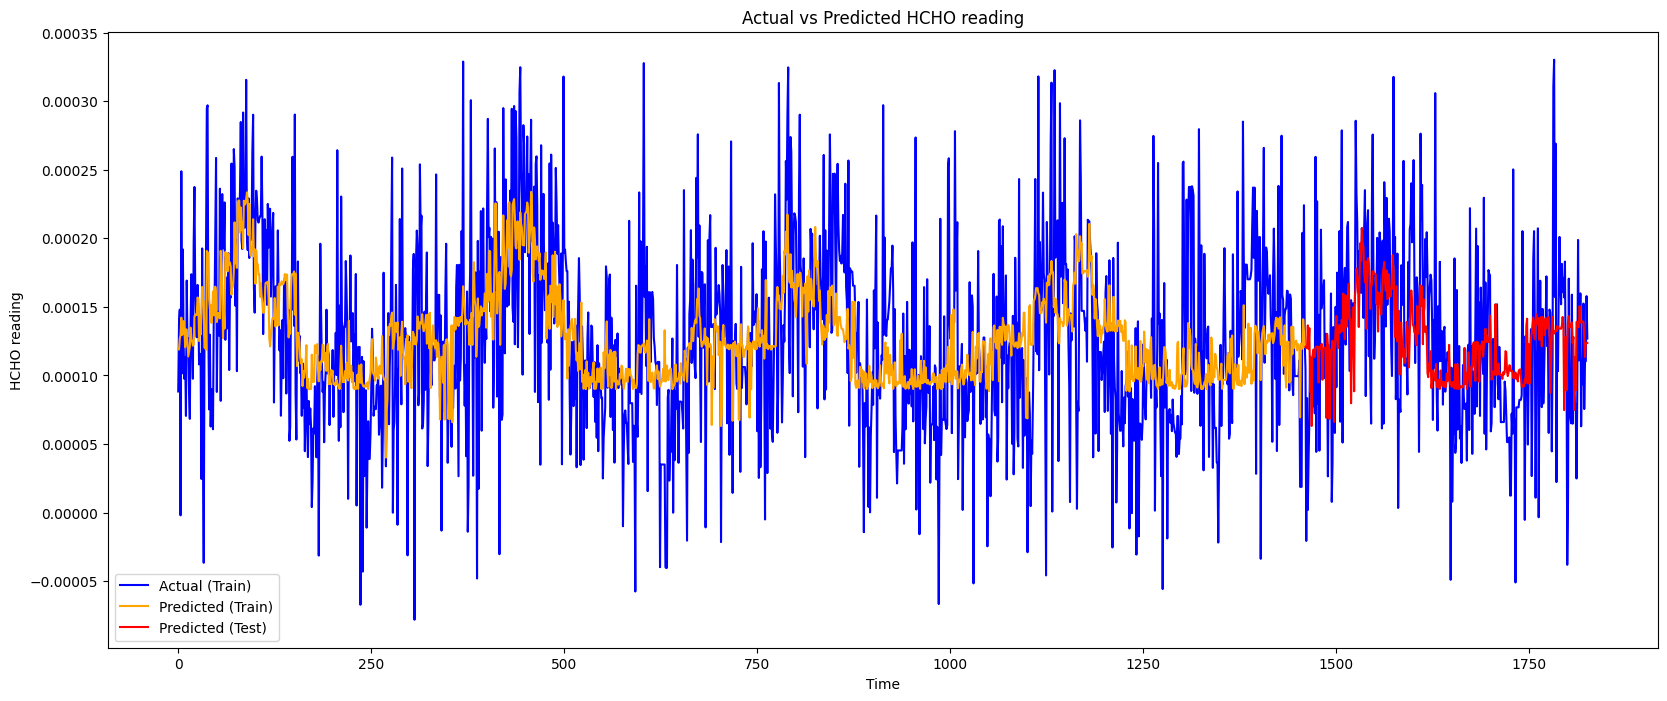

In [100]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(20, 8))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

#### However, it has given a R2 score of 0.145 and better mae ans mse values

In [118]:
r2 = (r2_score(actual_test, predictions_test))
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.14525245969916867
Mean Absolute Error (MAE): 4.565564405339549e-05
Mean Squared Error (MSE): 3.4029150011986713e-09
Root Mean Squared Error (RMSE): 5.833450952222596e-05
Median Absolute Error: 3.737363357035195e-05
Explained Variance Score: 0.14550660384496106


### Single variate models for Kurunegala

#### AR model Kurunegala

In [87]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Load data
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_ar = [] 

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(6, 0, 0))  # AR model with p=1, d=0, q=0 (since it's AR)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]  # Forecasting 1 step ahead
    yhat_ar.append(predictions)

yhat_ar = pd.Series(yhat_ar, index=test.index)
ar_mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Print or store the results
print("ARIMA MSE:", ar_mse)


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [11:27<00:00,  1.88s/it]

ARIMA MSE: 3.3258456487297313e-09


#### Predicted HCHO distribution for AR Model

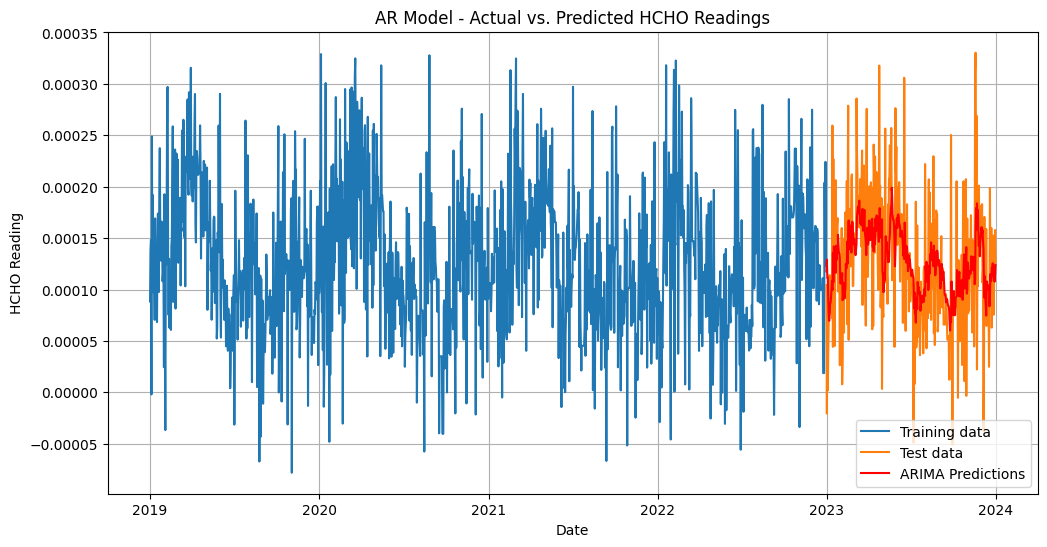

In [88]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_ar, label='ARIMA Predictions', color='red')
plt.title('AR Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

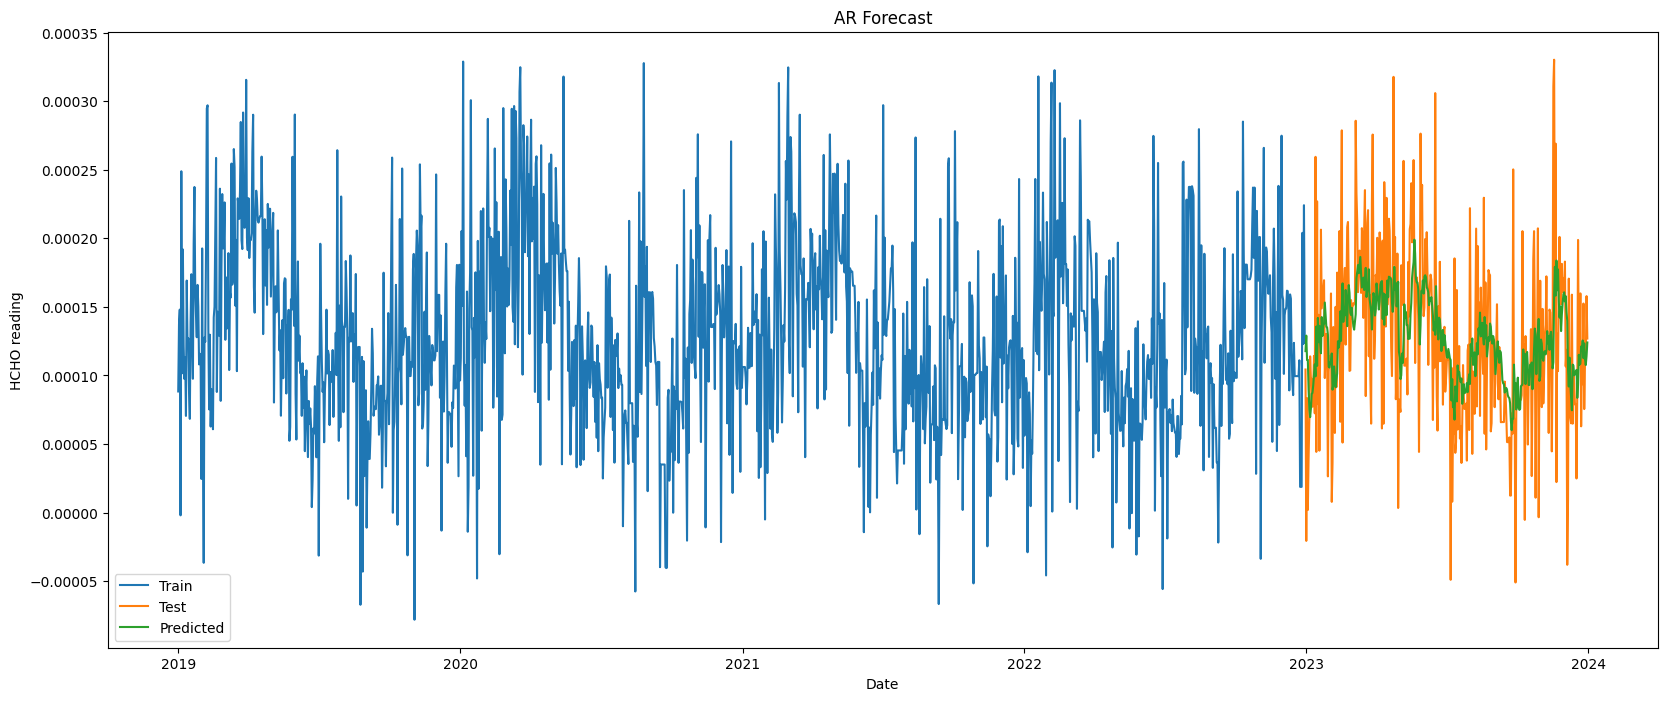

In [89]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train.index, train['HCHO reading'], label='Train')
plt.plot(test.index, test['HCHO reading'], label='Test')
plt.plot(test.index, yhat_ar, label='Predicted')

plt.title('AR Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO reading')
plt.legend()
plt.show()

#### It shows this model has caught the correct seasonal pattern, but the R2 Score is bit low

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_ar)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_ar) 

rmse = mean_squared_error(test['HCHO reading'], yhat_ar, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_ar)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_ar) 


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.2079365162275934e-05
Mean Squared Error (MSE): 3.3258456487297313e-09
R-squared (R2) Score: 0.1646108155300372
Root Mean Squared Error (RMSE): 5.7670145211623415e-05
Median Absolute Error: 3.059827036251097e-05
Explained Variance Score: 0.16470087550505685


### Kurunegala SARIMA model

#### Use the auto-correlation function to get best seasonal parameters of the dataset.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example using auto_arima
model = auto_arima(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'TMAX']],
                   seasonal=True, m=12,  # assuming monthly seasonality
                   trace=True)  # to display the model selection process
model_fit = model.fit(train['HCHO reading'], exogenous=train[['carbon_monoxide', 'TMAX']])

# Forecasting
forecast = model_fit.predict(n_periods=len(test), exogenous=test[['carbon_monoxide', 'TMAX']])

# Calculating MSE
sarima_mse = mean_squared_error(test['HCHO reading'], forecast)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-24224.909, Time=3.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23516.295, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-23849.107, Time=1.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24158.132, Time=15.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23518.303, Time=0.33 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-24226.293, Time=2.55 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-24231.426, Time=0.82 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-24229.408, Time=15.59 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-24230.509, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-24182.193, Time=4.80 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-24229.091, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-24231.238, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-24190.375, Time=5.40 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-23500.669, Tim

### ARIMA model

In [75]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Load data
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
   'carbon_monoxide': data["carbon_monoxide"],
   'TMAX': data["TMAX"],
   'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_arma = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(1, 0, 1))  # ARMA model with p=1,d=0,  q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]
    yhat_arma.append(predictions)

yhat_arma = pd.Series(yhat_arma, index=test.index)
arma_mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Print or store the results
print("ARIMA MSE:", arma_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [12:14<00:00,  2.01s/it]

ARIMA MSE: 3.3537400210314997e-09


#### This shows that it has caught the seasonal pattern of the dataset

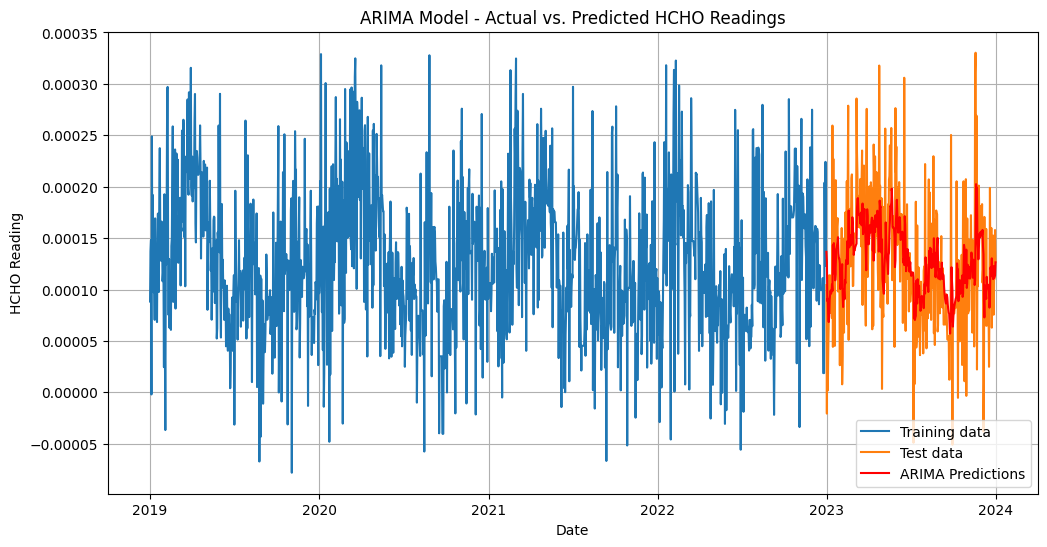

In [76]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

#### Seasonal pattern of the predicted testing dataset

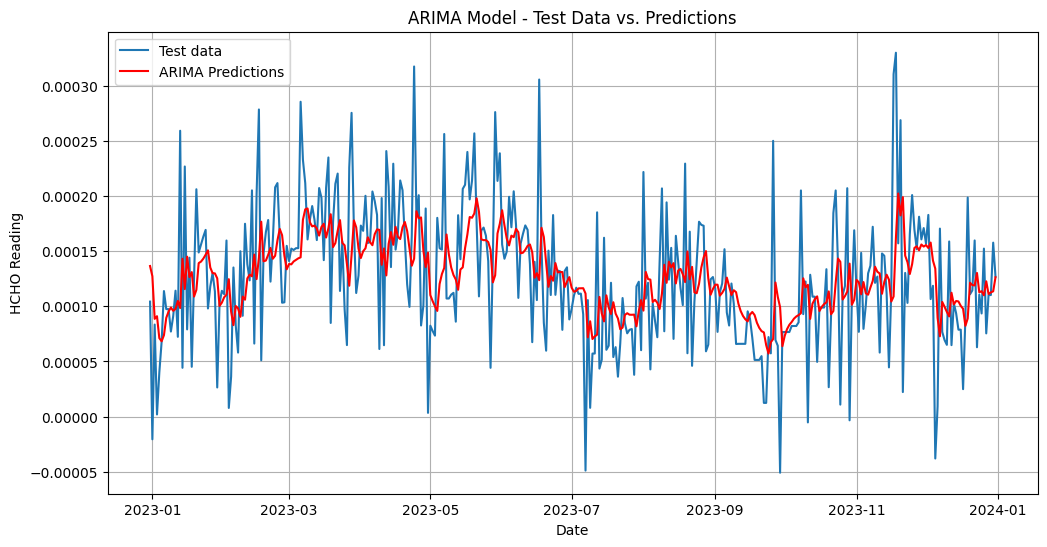

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

#### It has got better mse and mae values, but R2 score is bit low

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_arma)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_arma)

rmse = mean_squared_error(test['HCHO reading'], yhat_arma, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_arma)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_arma)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.22171946740143e-05
Mean Squared Error (MSE): 3.3537400210314997e-09
R-squared (R2) Score: 0.15760427963220436
Root Mean Squared Error (RMSE): 5.791148436218415e-05
Median Absolute Error: 3.0107689464651415e-05
Explained Variance Score: 0.15771897158221915


### Single Variate SARIMA model

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
   'carbon_monoxide': data["carbon_monoxide"],
   'TMAX': data["TMAX"],
   'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example
yhat_sarima = []

for t in tqdm(range(len(test['HCHO reading']))): 
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))  # SARIMA model with p=1,d=0,q=1 and seasonal order (P,D,Q,s) = (1,0,1,12)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=10)  # Forecasting 10 steps ahead
    yhat_sarima.append(predictions[-1])  # Appending only the last value of the forecast

yhat_sarima = pd.Series(yhat_sarima, index=test.index)
sarima_mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [17:32<00:00,  2.87s/it]

SARIMA MSE: 4.2589095643158225e-09


#### The SARIMA model shows that it has predicted the values by following the seasonality

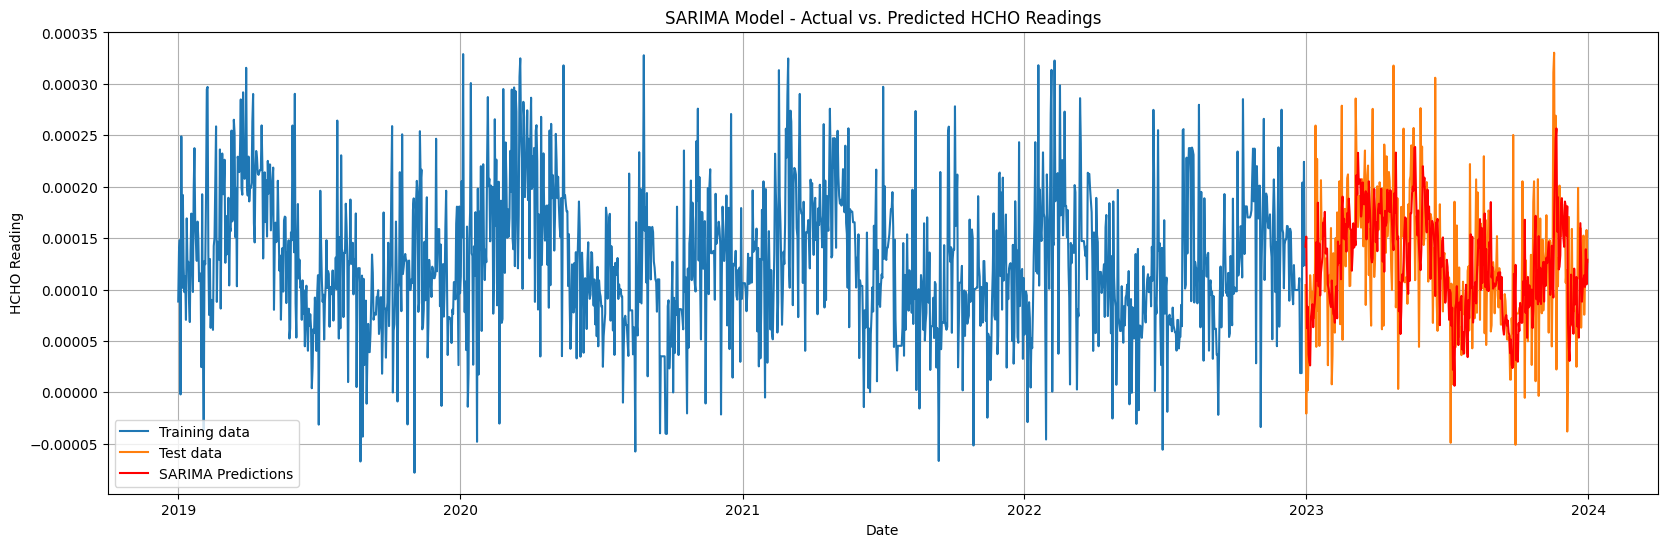

In [56]:
# Plotting
plt.figure(figsize=(20, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True) 
plt.show()

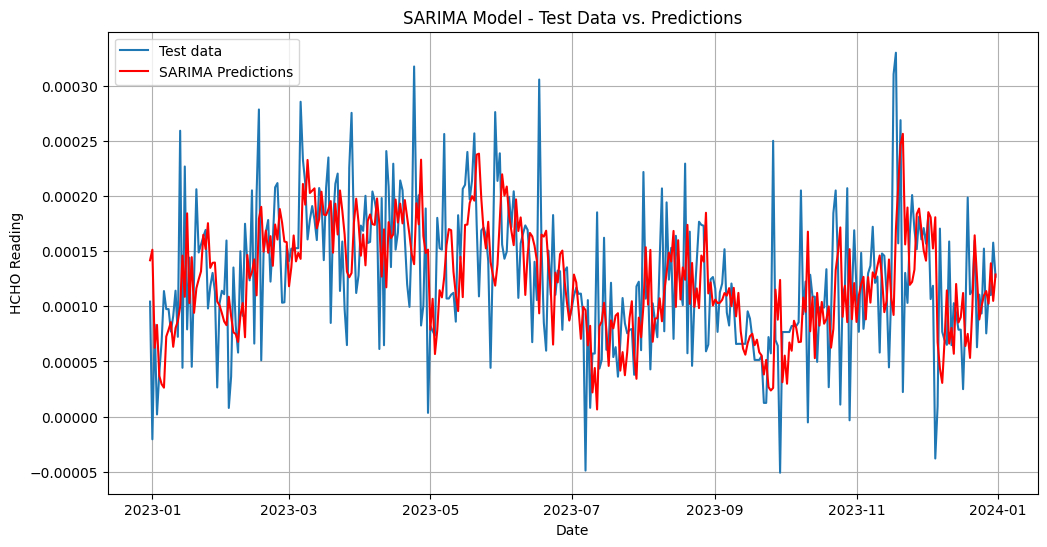

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

#### It has got a better mse, mae values. However, it has got a negativer R2 score.

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.728441764004943e-05
Mean Squared Error (MSE): 4.2589095643158225e-09
R-squared (R2) Score: -0.06975709742392855
Root Mean Squared Error (RMSE): 6.526032151557195e-05
Median Absolute Error: 3.210584744549829e-05
Explained Variance Score: -0.06906289239399421


## Multi Variate Models

### BayesianRidge Model

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
   'carbon_monoxide': data["carbon_monoxide"],
   'TMAX': data["TMAX"],
   'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TMAX','carbon_monoxide']].values
y_train = train['HCHO reading'].values
X_test = test[['TMAX', 'carbon_monoxide']].values
y_test = test['HCHO reading'].values

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Bayesian Regression
bayesian_reg = BayesianRidge()

# Fit the model
bayesian_reg.fit(X_train_scaled, y_train_scaled)

# Predictions
y_train_pred = bayesian_reg.predict(X_train_scaled)
y_test_pred = bayesian_reg.predict(X_test_scaled)

# Inverse transform to get actual values
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_actual))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 6.302859871212165e-05
Test RMSE: 5.757722582546295e-05


#### The below plot shows the bayesian Ridge model has caught the small fluctuations of the seasonality, However, 
#### it does not perform like other Time series based models

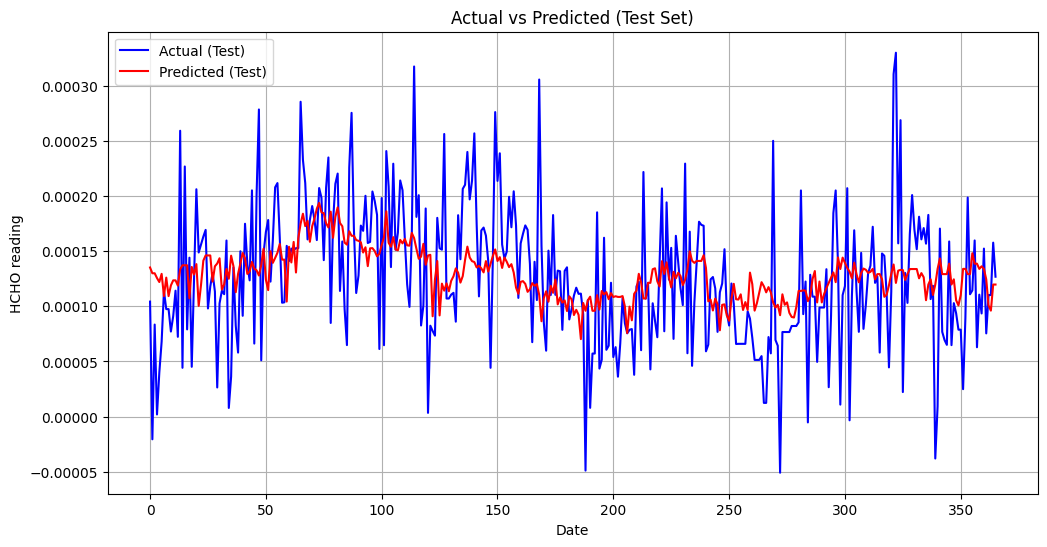

In [7]:
# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot([x for x in range(0, len(y_test))], y_test, label='Actual (Test)', color='blue')
plt.plot([x for x in range(0, len(y_test))], y_test_pred_actual, label='Predicted (Test)', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO reading') 
plt.legend()
plt.grid(True)
plt.show()

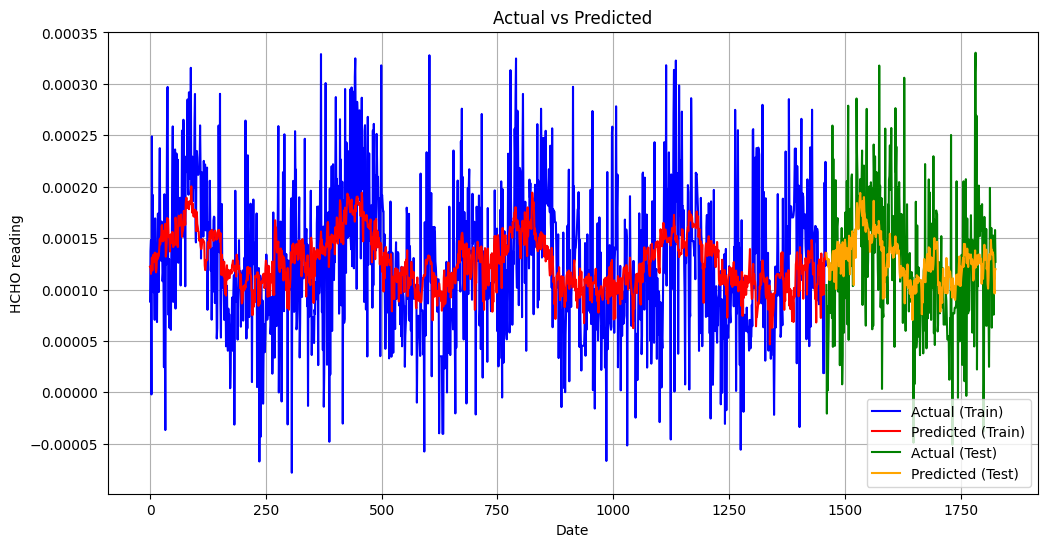

In [8]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for both training and test sets
plt.figure(figsize=(12, 6)) 
plt.plot(range(0, len(y_train)), y_train, label='Actual (Train)', color='blue')
plt.plot(range(0, len(y_train)), y_train_pred_actual, label='Predicted (Train)', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred_actual, label='Predicted (Test)', color='orange')
plt.title('Actual vs Predicted')
plt.xlabel('Date') 
plt.ylabel('HCHO reading')
plt.legend()
plt.grid(True)
plt.show()

#### It shows there is a better mae, mse scores, but R2 score is very low compared to the single variate LSTM model

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_actual)

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_actual)

# Calculate R2 score 
r2 = r2_score(y_test, y_test_pred_actual)

rmse = mean_squared_error(y_test, y_test_pred_actual, squared=False)

median_absolute = median_absolute_error(y_test, y_test_pred_actual) 
 
explained_variance = explained_variance_score(y_test, y_test_pred_actual)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.4424879037519167e-05
Mean Squared Error (MSE): 3.3151369337563582e-09
R-squared (R2) Score: 0.16730064110018783
Root Mean Squared Error (RMSE): 5.757722582546295e-05
Median Absolute Error: 3.675851498819582e-05
Explained Variance Score: 0.16864427283466388


### Random Forest Model

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Load the data
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
   'carbon_monoxide': data["carbon_monoxide"],
   'TMAX': data["TMAX"],
   'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TMAX', 'carbon_monoxide']].values
y_train = train['HCHO reading'].values
X_test = test[['TMAX', 'carbon_monoxide']].values
y_test = test['HCHO reading'].values

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Define the Random Forest model
random_forest_reg = RandomForestRegressor()

# Define the hyperparameters to search
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(random_forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best model
best_random_forest_reg = grid_search.best_estimator_

#### Get the best Parameters for Random Forest Regressor by Hyper Parameterized Optimization

In [16]:
# Predictions
y_train_pred = best_random_forest_reg.predict(X_train_scaled)
y_test_pred = best_random_forest_reg.predict(X_test_scaled)

# Inverse transform to get actual values
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_actual))

print("Best Parameters:", grid_search.best_params_)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}
Train RMSE: 5.054909064643764e-05
Test RMSE: 6.0287253828033435e-05


#### The below plot shows that Random Forest model has caught the seasonality, without having much fluctuations

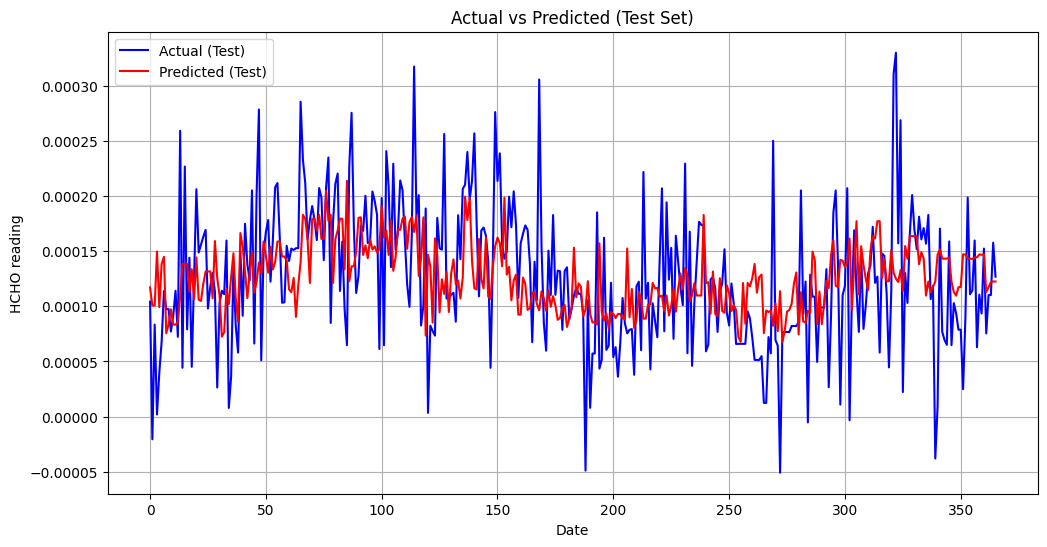

In [17]:
# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot([x for x in range(0, len(y_test))], y_test, label='Actual (Test)', color='blue')
plt.plot([x for x in range(0, len(y_test))], y_test_pred_actual, label='Predicted (Test)', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('HCHO reading') 
plt.legend()
plt.grid(True)
plt.show()

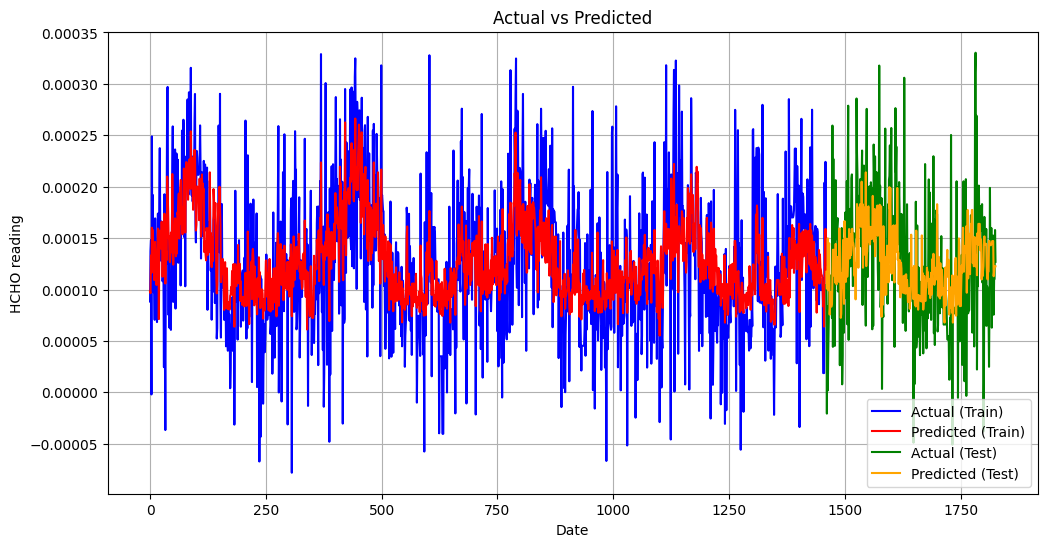

In [18]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for both training and test sets
plt.figure(figsize=(12, 6)) 
plt.plot(range(0, len(y_train)), y_train, label='Actual (Train)', color='blue')
plt.plot(range(0, len(y_train)), y_train_pred_actual, label='Predicted (Train)', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred_actual, label='Predicted (Test)', color='orange')
plt.title('Actual vs Predicted')
plt.xlabel('Date') 
plt.ylabel('HCHO reading')
plt.legend()
plt.grid(True)
plt.show()

#### It has got got a good mse and mae value, but R2 score is bit low compared with the Bayesian Regression model

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_actual)

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_actual)

# Calculate R2 score 
r2 = r2_score(y_test, y_test_pred_actual)

rmse = mean_squared_error(y_test, y_test_pred_actual, squared=False)

median_absolute = median_absolute_error(y_test, y_test_pred_actual) 
 
explained_variance = explained_variance_score(y_test, y_test_pred_actual)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.6366325646598543e-05
Mean Squared Error (MSE): 3.634552974125732e-09
R-squared (R2) Score: 0.08706940560292076
Root Mean Squared Error (RMSE): 6.0287253828033435e-05
Median Absolute Error: 3.643459531278184e-05
Explained Variance Score: 0.08707906785335717


### SARIMAX Multivariate Model

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pmdarima import auto_arima

In [21]:
# Load data
data = pd.read_csv("../AnalysedFinalData/kurunegalaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
   'carbon_monoxide': data["carbon_monoxide"],
   'TMAX': data["TMAX"],
   'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

In [29]:
from tqdm import tqdm
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Find the best parameters using auto_arima
# Fit the SARIMAX Model
exog_train = train[['carbon_monoxide', 'TMAX']]
endog_train = train['HCHO reading']

model = SARIMAX(endog_train, exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit(disp=False)

# Forecast
yhat_sarima = []
for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))  
    model_fit = model.fit()
    exog_test = test[['carbon_monoxide', 'TMAX']].iloc[t]
    predictions = model_fit.forecast(steps=1, exog=exog_test)  
    yhat_sarima.append(predictions[-1])  

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [29:54<00:00,  4.90s/it]


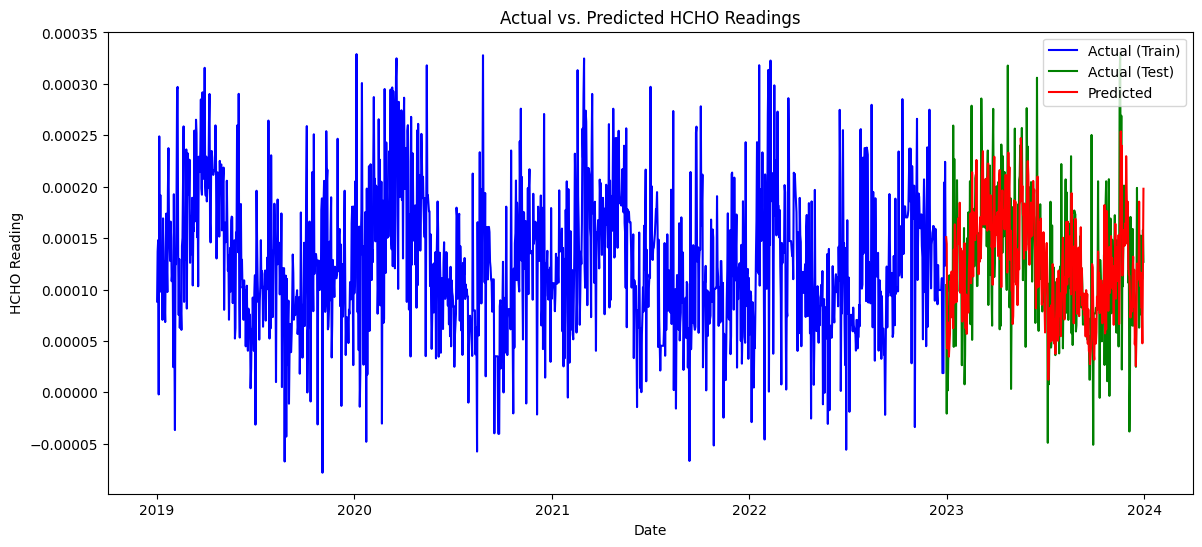

In [30]:
# Plotting
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train.index, train['HCHO reading'], label='Actual (Train)', color='blue')

# Plot testing data
plt.plot(test.index, test['HCHO reading'], label='Actual (Test)', color='green')

# Plot predicted values
plt.plot(test.index, yhat_sarima, label='Predicted', color='red')

plt.title('Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

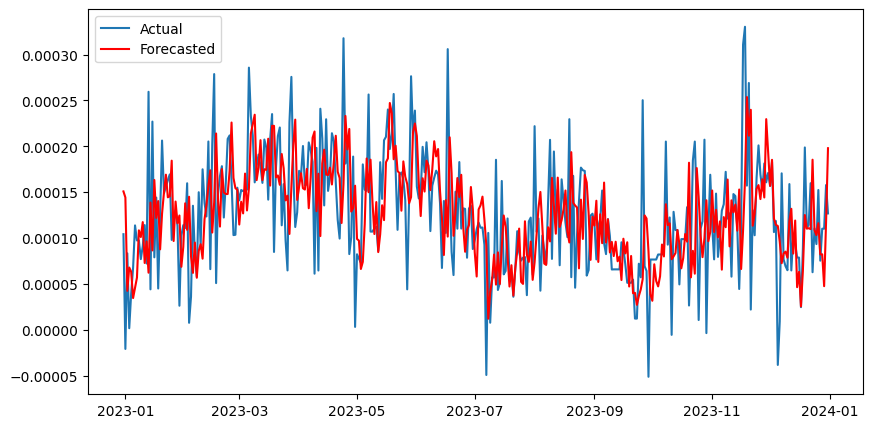

In [31]:
# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(test.index, test['HCHO reading'], label='Actual')
plt.plot(test.index, yhat_sarima, label='Forecasted', color='red')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.6397759336968645e-05
Mean Squared Error (MSE): 4.0038183889324705e-09
R-squared (R2) Score: -0.005683044844136065
Root Mean Squared Error (RMSE): 6.327573301774125e-05
Median Absolute Error: 3.3223367688059806e-05
Explained Variance Score: -0.0056601333822523525


In [33]:
#### Conclusion - The Single variate LSTM model (with Biderectional layers) has performed better than all other models.
#### From the multi variate models, 